In [2]:
import galsim
import batsim
import numpy as np
import numpy.lib.recfunctions as rfn
import matplotlib
import matplotlib.pyplot as plt
import anacal
import fpfs
import glob
import fitsio
from time import time

from tqdm import tqdm, trange

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['cmr10']
plt.rcParams['mathtext.fontset'] ='cm'
plt.rcParams['figure.facecolor'] = 'white'
plt.rc('axes', unicode_minus=False)
plt.rc('axes.formatter', use_mathtext=True)

Fix images that are too large

In [2]:
# Read in galaxy images with IA
# sim_dir = 'simulations/isolated_noiseless'
# file_list = glob.glob(sim_dir + '/*.fits')

# nn = 64
# scene_nn = nn * 2

# for f in tqdm(file_list):

#     gal_im = galsim.fits.read(f)

#     if gal_im.array.shape[0] != scene_nn:
#         bounds = galsim.BoundsI(1, scene_nn, 1, scene_nn)
#         gal_im = gal_im.subImage(bounds)
#         gal_im.write(f, clobber=True)
#     else:
#         pass

### FPFS shapelet kernel size and effective measurement radius
- Deconvolved galaxy Fourier power function is projected onto shapelet basis vectors
- FPFS parameter $\beta = \sigma_{shp} / r_{pp}$, where $r_{pp}$ is the scale radius of the of the PSF Fourier power function
- Projection of deconvolved galaxy converges only if shapelet basis vectors are more compact than the PSF, $\beta < 1$
- $r_{pp} = \sqrt{\frac{A}{\pi}}$

In [3]:
import astropy.io.fits as fits

# Read in galaxy images with IA
filename = 'simulations/isolated_noiseless/COSMOS_ngals=81499_noiseless.fits'

n_gals = 81499
n_scenes = 5
gals_per_scene = n_gals // n_scenes

total_indices = np.arange(0,n_gals)
split_inds = np.array_split(total_indices, n_scenes)

cosmos = galsim.COSMOSCatalog()
records = cosmos.getParametricRecord(np.arange(len(cosmos)))

i = 0
scene = []
hlrs = []
use_bulge = []
fluxes = []
records_inds = []
gal_ids = []
with fits.open(filename) as hdul:
    for j in tqdm(split_inds[i]):
        # exclude the first HDU
        data = hdul[j+1].data
        scene.append(data)

        gal_id = hdul[j+1].header['IDENT']
        gal_ids.append(gal_id)

        record_ind = np.where(records['IDENT'] == gal_id)[0][0]
        records_inds.append(record_ind)
        
        bulge = records['use_bulgefit'][record_ind]
        use_bulge.append(bulge)
        if bulge:
            hlrs.append(records['hlr'][record_ind][2])
            fluxes.append(records['flux'][record_ind][3])
        else:
            hlrs.append(records['hlr'][record_ind][0])
            fluxes.append(records['flux'][record_ind][0])

    gal_scene = np.concatenate(scene, axis=1)

 66%|██████▌   | 10759/16300 [00:24<00:12, 444.07it/s]


KeyboardInterrupt: 

Number of galaxies: 16300


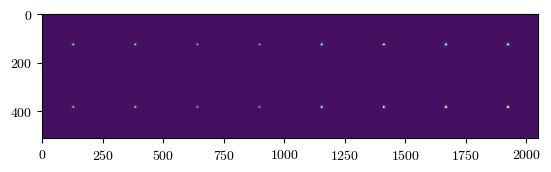

In [89]:
ngals = len(hlrs)
print(f'Number of galaxies: {ngals}')
norm = matplotlib.colors.Normalize(vmin=np.min(gal_scene), vmax=np.max(gal_scene)/1e3, clip=True)
plt.imshow(gal_scene[:,:512*4], norm=norm)

In [90]:
print(gal_scene.shape)

(512, 8345600)


In [91]:
scale = 0.2
scene_nx = gal_scene.shape[0]
scene_ny = gal_scene.shape[1]
nn = scene_ny // (2*ngals)

a_ia = galsim.Shear(e1=0.00136207, e2=0).g1
b_ia = 0.82404653
print(scale, scene_nx, scene_ny, nn, a_ia)

0.2 512 8345600 256 0.0006810353158702314


In [92]:
seeing = 0.8
psf = galsim.Moffat(beta=2.5, fwhm=0.8, trunc=seeing*4)
rcut = 16
psf_data = psf.shift(0.5*scale, 0.5*scale).drawImage(nx=nn, ny=nn, scale=scale, method='auto')
rpp = psf.scale_radius
beta_max = 0.99*rpp
print(rpp, beta_max)

0.7076510959648599 0.7005745850052113


In [93]:
# FPFS measurement function
def test_kernel_size(sigma_arcsec, psf_arr, gal_scene, scale, nx, ny, true_shear=None, get_mms=False):

    # initialize FPFS shear measurement task
    fpTask = fpfs.image.measure_source(psf_arr, sigma_arcsec=sigma_arcsec, pix_scale=scale)

    scene_nx = gal_scene.shape[0]
    scene_ny = gal_scene.shape[1]
    
    # force detection in specific order 
    indX = np.arange(int(nx/2), scene_nx, nx)
    indY = np.arange(int(ny/2), scene_ny, ny)
    inds = np.meshgrid(indY, indX, indexing="ij")
    coords = np.vstack([np.ravel(_) for _ in inds]).T
    coords = np.flip(coords, axis=1)    

    # measure shear with FPFS on entire scene
    mms = fpTask.measure(gal_scene, coords)
    mms = fpTask.get_results(mms)

    # convert momemnts to ellipticity estimates
    ells = fpfs.catalog.fpfs_m2e(mms, const=2000)
    resp = np.average(ells['fpfs_R1E'])
    shear = np.average(ells['fpfs_e1'])/resp

    if true_shear is not None:
        m_bias = abs(shear - true_shear)/true_shear
        if get_mms:
            return coords, shear, m_bias, ells, mms
        else:
            return coords, shear, m_bias, ells
    
    if get_mms:
        return coords, shear, ells, mms
    else:
        return coords, shear, ells

In [94]:
coords, shear, ells, mms = test_kernel_size(
                            0.5,
                            psf_data.array,
                            gal_scene,
                            scale,
                            nn,
                            nn,
                            true_shear=None,
                            get_mms=True
                        )

In [11]:
kernels = np.linspace(0.3, beta_max, 20)
rwfs = np.zeros((len(kernels), ngals))
sample_shears = np.zeros((len(kernels)))
larger_shears = np.zeros((len(kernels)))
smaller_shears = np.zeros((len(kernels)))
per_gal_shears = np.zeros((len(kernels), ngals))
per_gal_resp = np.zeros((len(kernels), ngals))
for i in trange(len(kernels)):
    coords, shear, ells = test_kernel_size(
                                kernels[i],
                                psf_data.array,
                                gal_scene,
                                scale,
                                nn,
                                nn
                            )

    sample_shears[i] = shear

    Lgal_shear = []
    Sgal_shear = []
    Lgal_resp = []
    Sgal_resp = []
    hlr_cut = seeing
    for j in range(ngals):
        max_ind = 4*(j+1)
        min_ind = j*4
        shear = np.average(ells[min_ind:max_ind]['fpfs_e1']) 
        resp = np.average(ells[min_ind:max_ind]['fpfs_R1E'])

        if hlrs[j] > hlr_cut:
            Lgal_shear.append(shear)
            Lgal_resp.append(resp)
        else:
            Sgal_shear.append(shear)
            Sgal_resp.append(resp)
        per_gal_shears[i,j] = shear
        per_gal_resp[i,j] = resp

        shear /= resp
        a_rwf = galsim.Shear(g1=shear).e1
        rwfs[i,j] = (a_rwf / a_ia) ** (1/b_ia)
        

    larger_shears[i] = np.average(Lgal_shear) / np.average(Lgal_resp)
    smaller_shears[i] = np.average(Sgal_shear) / np.average(Sgal_resp)

  0%|          | 0/20 [00:00<?, ?it/s]

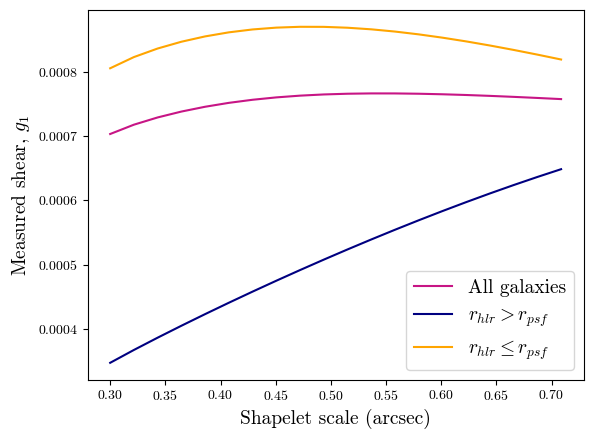

In [ ]:
plt.plot(kernels, sample_shears, color='mediumvioletred', label='All galaxies')
plt.plot(kernels, larger_shears, color='navy', label=r'$r_{hlr} > r_{psf}$')
plt.plot(kernels, smaller_shears, color='orange',label=r'$r_{hlr} \leq r_{psf}$')
plt.xlabel('Shapelet scale (arcsec)', fontsize=14)
plt.ylabel(r'Measured shear, $g_1$', fontsize=14)
plt.legend(fontsize=14)

plt.savefig('shear_shapelets.pdf', dpi=300, bbox_inches='tight')

Number of large galaxies: 52
Number of small galaxies: 948


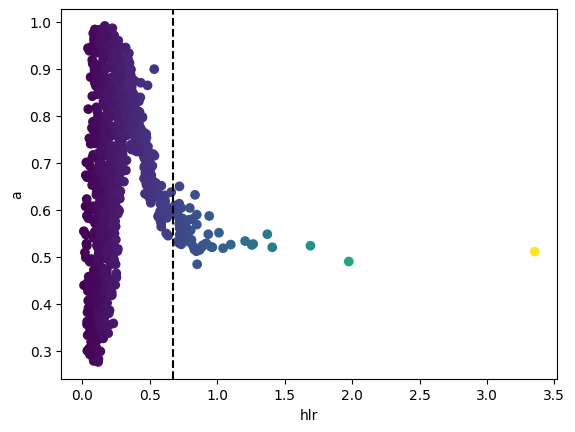

In [ ]:
delta_y = np.zeros(ngals)
a = np.zeros(ngals)
for i in range(ngals):
    y1 = np.max(per_gal_shears[:,i] / per_gal_resp[:,i])
    y2 = np.min(per_gal_shears[:,i] / per_gal_resp[:,i])
    
    delta_y[i] = y1 - y2
    a[i] = y2/y1

#plt.scatter(hlrs, delta_y)
plt.scatter(hlrs, a, c=hlrs)
plt.axvline(seeing, color='k', linestyle='--')
plt.ylabel('a')
plt.xlabel('hlr')

hlrs_arr = np.array(hlrs)
nbig = np.sum(hlrs_arr > seeing)
nsmall = np.sum(hlrs_arr <= seeing)
print(f'Number of large galaxies: {nbig}')
print(f'Number of small galaxies: {nsmall}')

In [ ]:
# Compute combinations of shear pairs
yij = []
aij = []

for i in range(len(kernels)):
    for j in range(len(kernels)):
        if i != j and i <= j:
            y = sample_shears[j] - sample_shears[i]
            a = sample_shears[i]/sample_shears[j]
            yij.append(y)
            aij.append(a)
    
yij = np.array(yij[:len(kernels)])
aij = np.array(aij[:len(kernels)])

print("{:.6e}".format(a_ia))

print(yij)
y_boost = np.sum(yij)
print("{:.6e}".format(y_boost))

print(aij)
a_boost = aij[0] * aij[1] * aij[2]
print("{:.6f}".format(a_boost))

6.810353e-04
[1.44821915e-05 2.57372087e-05 3.48672768e-05 4.23426736e-05
 4.84009457e-05 5.32053726e-05 5.68969918e-05 5.96082664e-05
 6.14651997e-05 6.25861427e-05 6.30803233e-05 6.30469044e-05
 6.25745291e-05 6.17413245e-05 6.06154706e-05 5.92558223e-05
 5.77128108e-05 5.60294357e-05 5.42418856e-05 1.12550172e-05]
1.009146e-03
[0.97981824 0.96468758 0.95275264 0.94319839 0.93559479 0.92965148
 0.92513581 0.92184716 0.91960825 0.91826198 0.91766971 0.91770974
 0.9182759  0.91927625 0.92063142 0.92227334 0.92414379 0.92619307
 0.92837915 0.98455769]
0.900559


20


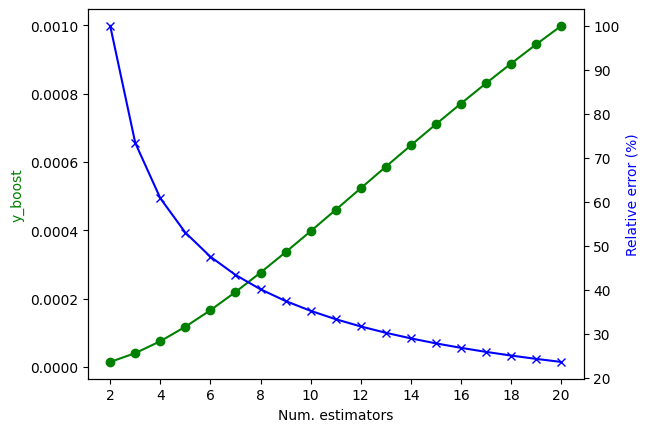

In [ ]:
y_boost = np.zeros(len(kernels))
err = np.zeros(len(kernels))

for i in range(1, len(kernels)):
    y_boost[i] = np.sum(yij[:i])
    err[i] = np.sqrt(np.sum(np.array(yij[:i])**2))
    err[i] /= np.abs(y_boost[i])
    err[i] *= 100

print(len(y_boost))
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

n_est = np.arange(2, len(kernels)+1)
ax1.plot(n_est, y_boost[1:], 'g-', marker='o')
ax2.plot(n_est, err[1:], 'b-', marker='x')

ax1.set_xlabel('Num. estimators')
ax1.set_ylabel('y_boost', color='g')
ax2.set_ylabel('Relative error (%)', color='b')

plt.xticks(np.arange(1,11)*2);

In [ ]:
print(sample_shears[-1]/sample_shears[0])
print(larger_shears[0]/larger_shears[-1])
print(smaller_shears[-1]/smaller_shears[0])

1.0771461257181085
0.5359663534304846
1.016893658274432


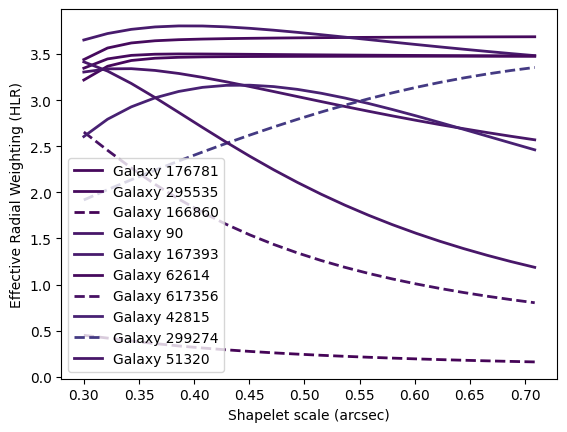

In [ ]:
# create color map based on galaxy 
# half light radius
minima = min(hlrs)
maxima = max(hlrs)

norm = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
mapper = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.viridis)

hlr_cut = seeing
for i in range(ngals):
    if hlrs[i] < hlr_cut:
        if i % 100 == 0:
            color = mapper.to_rgba(hlrs[i])
            if use_bulge[i]:
                plt.plot(kernels, rwfs[:,i], c=color, lw=2, ls='--', label=f'Galaxy {gal_ids[i]}')
            else:
                plt.plot(kernels, rwfs[:,i], c=color, lw=2, ls='-', label=f'Galaxy {gal_ids[i]}')

plt.xlabel('Shapelet scale (arcsec)')
plt.ylabel('Effective Radial Weighting (HLR)')
plt.legend()
#print(f'Number of galaxies with HLR > {hlr_cut}: {ncut}')

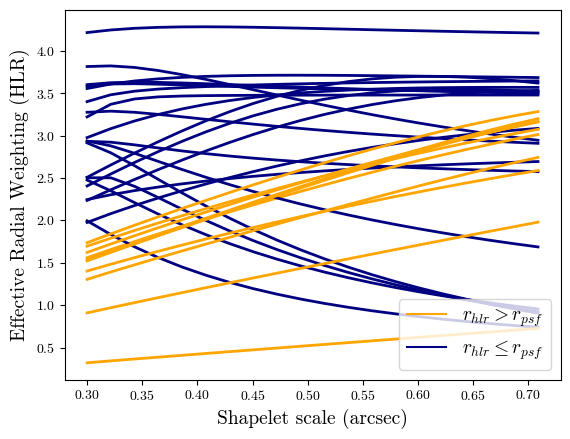

In [ ]:
nbig = 0
nsmall = 0
for i in range(ngals):
        if hlrs[i] > hlr_cut:
            if nbig < 10:
                plt.plot(kernels, rwfs[:,i], c='orange', lw=2, ls='-')
                nbig += 1
        else:
            if nsmall < 20:
                plt.plot(kernels, rwfs[:,i], c='navy', lw=2, ls='-')
                nsmall += 1

# create proxy artist for legend
plt.plot([], [], color='orange', label=r'$r_{hlr} > r_{psf}$')
plt.plot([], [], color='navy', label=r'$r_{hlr} \leq r_{psf}$')
plt.legend(fontsize=14, loc='lower right')

plt.xlabel('Shapelet scale (arcsec)', fontsize=14)
plt.ylabel('Effective Radial Weighting (HLR)', fontsize=14)
plt.savefig('rwfs_shapelets.pdf', dpi=300, bbox_inches='tight')

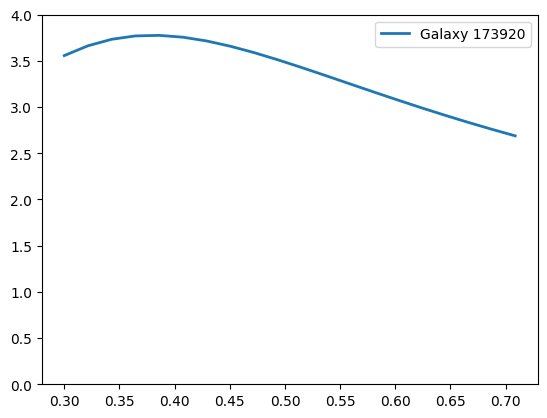

In [ ]:
i = 33
plt.plot(kernels, rwfs[:,i], lw=2, ls='-', label=f'Galaxy {gal_ids[i]}')
plt.ylim(0, 4)
plt.legend()

Radial weight function (defined as a ratio of measurement radius to half light radius) with shapelet kernel size. Each line represents an individual galaxy and is coloured proportional to it's half-light radius.

### Investigate Correlation with galaxy properties

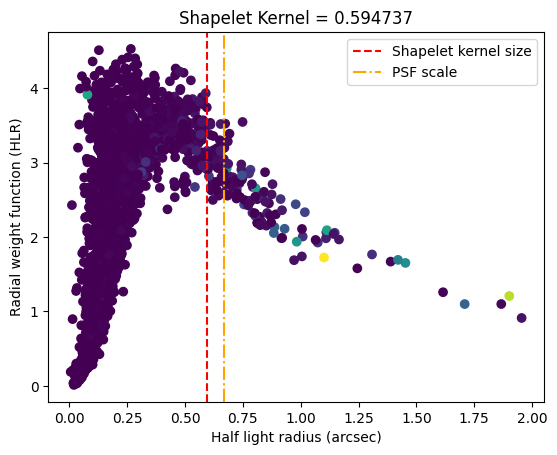

In [ ]:
# Pick middle kernel size
i = -12
plt.figure()
plt.title('Shapelet Kernel = {:3f}'.format(kernels[i]))
plt.scatter(hlrs, rwfs[i,:], marker='o', c=fluxes, cmap='viridis')
plt.axvline(kernels[i], ls='--', c='r', label='Shapelet kernel size')
plt.axvline(seeing, ls='-.', c='orange', label='PSF scale')
plt.legend()
plt.xlabel('Half light radius (arcsec)')
plt.ylabel('Radial weight function (HLR)')
plt.savefig('plots/rwf_vs_hlr.png')

Radial weight function (defined as a ratio of measurement radius to half light radius) v.s. the half light radius of the galaxy. Points represent individual galaxies and are coloured proportional to their flux.

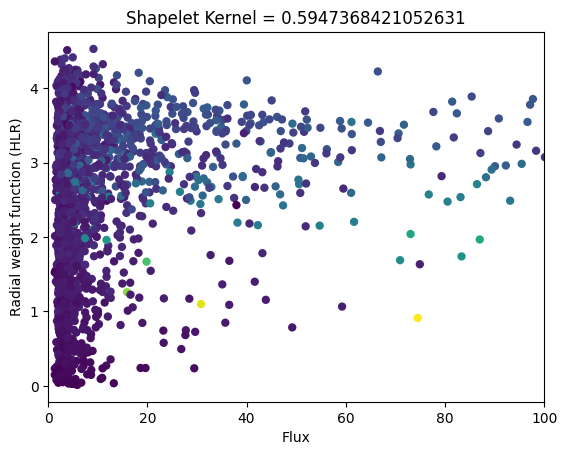

In [ ]:
plt.figure()
plt.title('Shapelet Kernel = {}'.format(kernels[i]))
plt.scatter(fluxes, rwfs[i,:], lw=0, marker='o', c=hlrs, cmap='viridis')
plt.xlim(0, 100)
plt.xlabel('Flux')
plt.ylabel('Radial weight function (HLR)')
plt.savefig('plots/rwf_vs_flux.png')

Radial weight function (defined as a ratio of measurement radius to half light radius) v.s. the flux of the galaxy. Points represent individual galaxies and are coloured proportional to their half light radius.

### Attempt to modify apperture cut instead to measure shear gradient

In [ ]:

# define the method used for shear estimation
method_obj = anacal.dtype.FPFSMethod(
    sigma_as=0.5,        # smoothing scale for shape estimation
    sigma_det=0.5,       # smoothing scale for detection
    rcut=32,             # radius of the stamp 
    nnord=4,             # order of shapelets
    noise_rev=False,     # whether do noise bias correction
)
cat_obj = anacal.process.process_image(data_obj, method_obj)
# test the wrapped impt.FPFS function

outcome = anacal.process.measure_shear(cat_obj, method_obj)
shear1 = np.sum(outcome[:, 0]) / np.sum(outcome[:, 1])
print("input g1 is %.5f" % shear_value)
print("measured g1 is %.5f" % shear1)

shear2 = np.sum(outcome[:, 2]) / np.sum(outcome[:, 3])
print("input g2 is 0.")
print("measured g2 is %.5f" % shear2)

AttributeError: module 'anacal.simulation' has no attribute 'make_isolate_sim'

In [ ]:
def test_apperture_size(rcut, psf_arr, gal_scene, scale, true_shear=None, get_mms=False):

    scene_nx = gal_scene.shape[0]
    scene_ny = gal_scene.shape[1]

    ngrid = rcut * 2
    
    # force detection at center
    indx = np.arange(ngrid // 2, ngrid * scene_nx, ngrid)
    indy = np.arange(ngrid // 2, ngrid * scene_ny, ngrid)
    inds = np.meshgrid(indy, indx, indexing="ij")
    coords = np.vstack(inds).T
    buff = 0

    fpfs_config = anacal.fpfs.FpfsConfig(
        force=False, rcut=rcut,
        gmeasure=3,
    )

    psf_array = psf_arr[
        ngrid // 2 - rcut : ngrid // 2 + rcut,
        ngrid // 2 - rcut : ngrid // 2 + rcut,
    ]   

    outcomes = anacal.fpfs.process_image(
        fpfs_config=fpfs_config,
        gal_array=gal_scene,
        psf_array=psf_array,
        pixel_scale=scale,
        coords=coords,
        noise_array=None,
        noise_variance=1,
        cov_matrix=None
    )

    shear = np.sum(outcomes[:, 0]) / np.sum(outcomes[:, 1])

    return shear, outcomes

In [ ]:
shear, outcomes = test_apperture_size(
                        rcut=16,
                        psf_arr=psf_data.array,
                        gal_scene=gal_scene,
                        scale=scale
                    )

/tmp/ipykernel_1354667/2277530586.py:36: RuntimeWarning: invalid value encountered in scalar divide
  shear = np.sum(outcomes[:, 0]) / np.sum(outcomes[:, 1])


In [ ]:
print(shear)

nan


### Try and fit Chebyshev polynomials to the RWF curves

Text(0, 0.5, '$r_{wf}^{fit} \\, / \\, r_{wf}^{true}$')

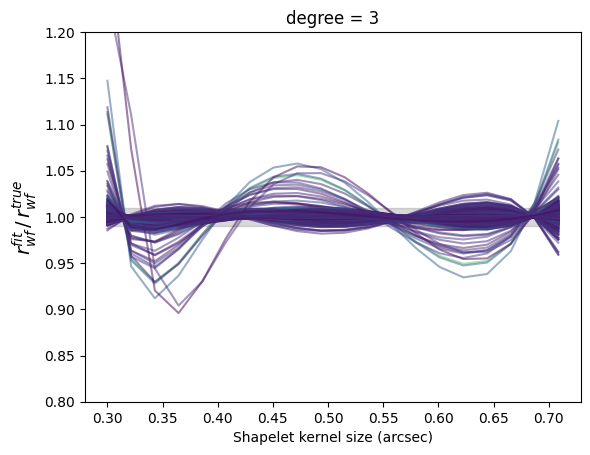

In [ ]:
from numpy.polynomial.chebyshev import Chebyshev

for i in range(ngals):
    if i % 1 == 0:
        color = mapper.to_rgba(hlrs[i])
        degree = 3
        cheb = Chebyshev.fit(kernels, rwfs[:,i], degree)

        y_fits = cheb(kernels)

        # plot the fractional residuals of the fit
        plt.plot(kernels, y_fits/rwfs[:,i], c=color, alpha=0.5)

plt.fill_between(kernels, y1=0.99, y2=1.01, color='gray',alpha=0.3)
plt.ylim(0.8, 1.2)
plt.title('degree = {}'.format(degree))
plt.xlabel('Shapelet kernel size (arcsec)')
plt.ylabel(r'$r_{wf}^{fit} \, / \, r_{wf}^{true}$', fontsize=14)

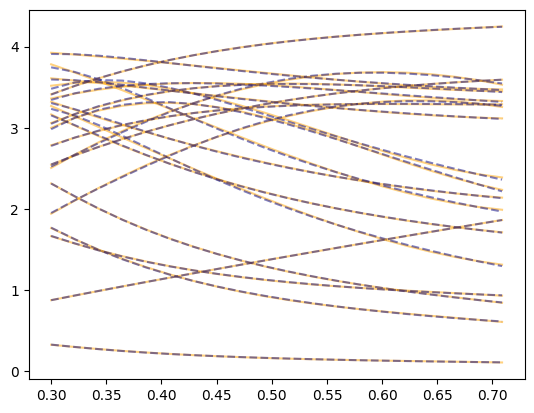

In [ ]:
for i in range(ngals):
    if i % 50 == 0:
        color = mapper.to_rgba(hlrs[i])
        degree = 3
        cheb = Chebyshev.fit(kernels, rwfs[:,i], degree)

        y_fits = cheb(kernels)

        # plot the fractional residuals of the fit
        plt.plot(kernels, y_fits, c='orange', alpha=0.5, ls='-')
        plt.plot(kernels, rwfs[:,i], c='navy', alpha=0.5, ls='--')

### Fit regression model to predict effective measurement radius for different galaxies and different kernels

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [ ]:
# load in all galaxy parameters possible from records dict
# and create a feature matrix
keys = records.keys()
keys = [key for key in keys if key not in ['IDENT', 'use_bulgefit', 'viable_sersic']]

feature_list = []
n_features = 0
# creates a list of 42 feature arrays, each with 4000 elements
for key in keys:
    if type(records[key][0]) == np.ndarray:
        for i in range(len(records[key][0])):
            feature_list.append(records[key][records_inds][:,i])
            n_features += 1
    else:
        feature_list.append(records[key][records_inds])
        n_features += 1

print(n_features)

42


False False
(1000, 42) (1000, 20)


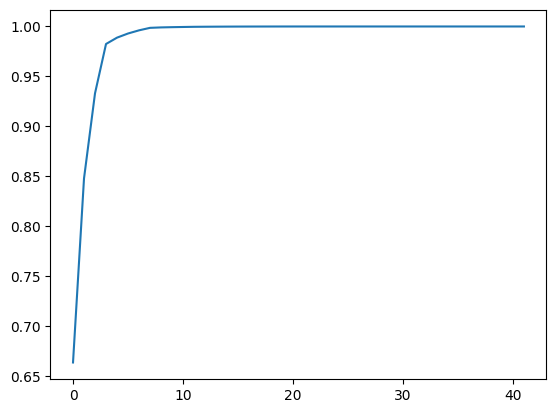

In [ ]:
# Now each row is a galaxy, and each column is a feature
X = np.vstack(feature_list).T

# Attempt to use PCA to reduce dims
pca = PCA(n_components=42)
X = pca.fit_transform(X)

# Plot explained variance for each component
plt.plot(np.cumsum(pca.explained_variance_ratio_))

# Model should take 42 features and return a rwf value for 20 kernel sizes
# X.shape = (ngals, n_features)
# Y.shape = (ngals, 20)
Y = rwfs.T

# fill in missing values
inds = np.where(np.isnan(Y))
Y[inds] = 0

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print(np.isnan(y_train).any(), np.isnan(y_test).any())
print(X.shape, Y.shape)

# Scale data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Instantiate model
mlp = MLPRegressor(hidden_layer_sizes=(16,32,64,32,16), max_iter=1000, alpha=0.0001,
                    solver='adam', verbose=1, random_state=42, tol=1e-4, learning_rate_init=0.001)

# Train model
mlp.fit(X_train, y_train)

# Predict on test set
y_pred = mlp.predict(X_test)

# Score model
score = mlp.score(X_test, y_test)

Iteration 1, loss = 3.54147291
Iteration 2, loss = 3.50324710
Iteration 3, loss = 3.47719557
Iteration 4, loss = 3.44396363
Iteration 5, loss = 3.40053234
Iteration 6, loss = 3.33702735
Iteration 7, loss = 3.23679007
Iteration 8, loss = 3.10905330


Iteration 9, loss = 2.97171605
Iteration 10, loss = 2.82513483
Iteration 11, loss = 2.68624536
Iteration 12, loss = 2.54105001
Iteration 13, loss = 2.38509000
Iteration 14, loss = 2.22443297
Iteration 15, loss = 2.06634808
Iteration 16, loss = 1.91331822
Iteration 17, loss = 1.75998599
Iteration 18, loss = 1.60556011
Iteration 19, loss = 1.45872713
Iteration 20, loss = 1.30729072
Iteration 21, loss = 1.16194349
Iteration 22, loss = 1.02203237
Iteration 23, loss = 0.89049250
Iteration 24, loss = 0.77241035
Iteration 25, loss = 0.66936002
Iteration 26, loss = 0.58500229
Iteration 27, loss = 0.51224820
Iteration 28, loss = 0.45582393
Iteration 29, loss = 0.40919843
Iteration 30, loss = 0.37579848
Iteration 31, loss = 0.34946289
Iteration 32, loss = 0.32910561
Iteration 33, loss = 0.31441620
Iteration 34, loss = 0.30255257
Iteration 35, loss = 0.29295210
Iteration 36, loss = 0.28571233
Iteration 37, loss = 0.27896508
Iteration 38, loss = 0.27343715
Iteration 39, loss = 0.26828450
Iteration

0.15922515672687312


Text(0, 0.5, 'Radial weight function (HLR)')

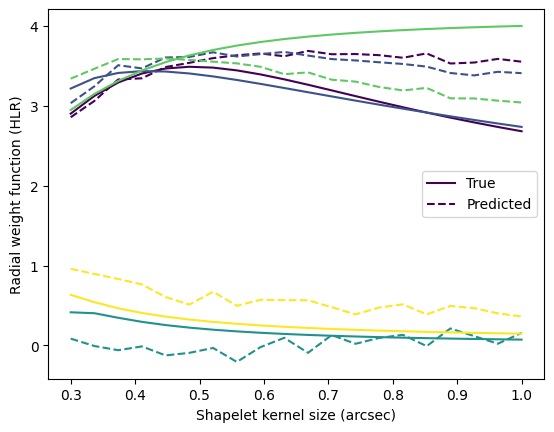

In [ ]:
print(score)
n_plot = len(y_test) // 40

colors = plt.cm.viridis(np.linspace(0,1,n_plot))

for i in range(n_plot):
    plt.plot(kernels, y_test[i], c=colors[i])
    plt.plot(kernels, y_pred[i], c=colors[i], ls='--')

plt.legend(['True'] + ['Predicted'])
plt.xlabel('Shapelet kernel size (arcsec)')
plt.ylabel('Radial weight function (HLR)')